In [1]:
# init block
%matplotlib inline
import numpy as np
import pylab as plt
import pandas as pd

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

## ADT Data

In [2]:
adt = pd.read_csv('./Bios366_project_data/FONNESBECK_ADT.csv', parse_dates=[2,3,6])

Separate out the admits and the discharges:

In [3]:
admits = adt[adt.Event=='ADT ADMIT']
discharges = adt[adt.Event=='ADT DISCHARGE']
discharges=discharges.sort(columns=['RUID','Admission_date','DISCHARGE_DATE'])
admits=admits.set_index(['RUID','Admission_date'])
discharges=discharges.set_index(['RUID','Admission_date'])

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


Get rid of duplicate entries for admission codes from the ADT stream

In [4]:
admits=admits.groupby(level=admits.index.names).last()

We are going to get rid of duplicate discharge codes usually because the patient had an initial discharge order that was cancelled and then had a new discharge order placed at a later date. So we will pick the last entry when there are multiple discharges for a particular patient and admission date

In [5]:
discharges=discharges.groupby(level=discharges.index.names).last()

Drop the 'discharge date' from the admits dataframe because this is empty and then drop the complementary columns from the discharges dataframe. Then we merge the two dataframes so we can match admits with discharges

In [6]:
admits.drop('DISCHARGE_DATE',1,inplace=True)
discharges.drop(['Event','Event_Date','SRV_CODE','CHIEF_COMPLAINT'],1,inplace=True)
df=pd.concat([admits, discharges],axis=1)

Find the difference between the discharge date and the next admission date for each patient.

In [7]:
from datetime import timedelta

groups=df.groupby(level='RUID')
days_to_readmit=groups.apply(lambda x: abs(x.DISCHARGE_DATE.shift() - x.index.get_level_values(1)).shift(-1))
df['days_to_readmit']=days_to_readmit.values
df['readmission']=df.days_to_readmit.apply(lambda x: False if pd.isnull(x) else (x <=np.timedelta64(30,'D')))

In [8]:
df.head()

                         Event Event_Date SRV_CODE            CHIEF_COMPLAINT  \
RUID Admission_date                                                             
124  2013-01-24      ADT ADMIT 2013-01-24      GAS    BLEEDING AT OSTOMY SITE   
     2013-01-30      ADT ADMIT 2013-01-30      PUL             LOWER GI BLEED   
163  2006-11-18      ADT ADMIT 2006-11-18      CTS        CAD LT MAIN DISEASE   
178  2007-10-20      ADT ADMIT 2007-10-20      CTS                        CAD   
453  2006-08-05      ADT ADMIT 2006-08-05      GNS  COLO RECTAL CA LIVER METS   

                    DISCHARGE_DATE  days_to_readmit readmission  
RUID Admission_date                                              
124  2013-01-24         2013-01-27           3 days        True  
     2013-01-30         2013-02-01              NaT       False  
163  2006-11-18         2006-11-24              NaT       False  
178  2007-10-20         2007-10-26              NaT       False  
453  2006-08-05         2006-08-11  

In [9]:
df.reset_index(inplace=True)

In [10]:
df.head()

   RUID Admission_date      Event Event_Date SRV_CODE  \
0   124     2013-01-24  ADT ADMIT 2013-01-24      GAS   
1   124     2013-01-30  ADT ADMIT 2013-01-30      PUL   
2   163     2006-11-18  ADT ADMIT 2006-11-18      CTS   
3   178     2007-10-20  ADT ADMIT 2007-10-20      CTS   
4   453     2006-08-05  ADT ADMIT 2006-08-05      GNS   

             CHIEF_COMPLAINT DISCHARGE_DATE  days_to_readmit readmission  
0    BLEEDING AT OSTOMY SITE     2013-01-27           3 days        True  
1             LOWER GI BLEED     2013-02-01              NaT       False  
2        CAD LT MAIN DISEASE     2006-11-24              NaT       False  
3                        CAD     2007-10-26              NaT       False  
4  COLO RECTAL CA LIVER METS     2006-08-11         491 days       False  

### Look up BMI data

We need to drop some rows with malformed dates so we check to see if the date parser can parse the date or not

In [11]:
bmi = pd.read_csv('./Bios366_project_data/FONNESBECK_BMI.csv', parse_dates=['Date_BMI',])
bmi.Date_BMI=bmi.Date_BMI.apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='ignore'))
bmi.drop(bmi[bmi.Date_BMI.apply(lambda x: type(x)) != pd.tslib.Timestamp].index,inplace=True)

In [12]:
bmi=bmi.set_index('RUID')
bmi.sort_index(inplace=True)

In [13]:
bmigroups=bmi.groupby(level=0)

In [14]:
bmi_df = pd.DataFrame(index=df.index, columns=['BMI'])

In [17]:
bmi_df.head()

   BMI
0  NaN
1  NaN
2  NaN
3  NaN
4  NaN

Calculate the patient's average BMI using values 365 days before admission up until admission.

In [18]:
bmi_df['BMI'] = df.apply(lambda x: np.mean(bmigroups.get_group(x.RUID)
                                     [(x.Admission_date - bmigroups.get_group(x.RUID).Date_BMI <= np.timedelta64(365,'D')) 
                                      & (x.Admission_date - bmigroups.get_group(x.RUID).Date_BMI >= np.timedelta64(0,'D'))
                                     ].BMI
                                    ) if x.RUID in bmi.index else 'NaN', axis=1)

In [29]:
bmi_df.head()

       BMI
0   53.305
1  52.6467
2      NaN
3      NaN
4   32.824

### Pull in the eGFR data

In [19]:
gfr = pd.read_csv('./Bios366_project_data/FONNESBECK_EGFR.csv', parse_dates=['egfr_date',])

In [20]:
gfr=gfr.set_index('RUID')
gfrgroups=gfr.groupby(level=0)

Let's create a dataframe to house 4 summary statistics of the patient's GFR. Their admission GFR (the average GFR during the first 48 hours of admission), the discharge GFR (the average GFR during the last 48 hours of admission), the min GFR, and the maximum GFR.

In [21]:
gfr_df=pd.DataFrame(index=df.index, columns=['gfr_admit','gfr_discharge','gfr_min','gfr_max'])

We'll include GFRs from 12 hours prior to admission to capture any laboratory values that were obtained while the patient was in the emergency room.

In [22]:
gfr_df['gfr_admit']=df.apply(lambda x: np.mean(gfrgroups.get_group(x.RUID)
                          [(gfrgroups.get_group(x.RUID).egfr_date >= (x.Admission_date-np.timedelta64(12,'h')))
                            &(gfrgroups.get_group(x.RUID).egfr_date <= (x.Admission_date+np.timedelta64(48,'h')))
                          ].EGFR
                          ) if x.RUID in gfr.index else 'NaN', axis=1)

In [23]:
gfr_df['gfr_discharge']=df.apply(lambda x: np.mean(gfrgroups.get_group(x.RUID)
                          [(gfrgroups.get_group(x.RUID).egfr_date >= (x.DISCHARGE_DATE-np.timedelta64(48,'h')))
                            &(gfrgroups.get_group(x.RUID).egfr_date <= (x.DISCHARGE_DATE))
                          ].EGFR
                          ) if x.RUID in gfr.index else 'NaN', axis=1)

In [24]:
gfr_df['gfr_min']=df.apply(lambda x: np.min(gfrgroups.get_group(x.RUID)
                          [(gfrgroups.get_group(x.RUID).egfr_date >= (x.Admission_date-np.timedelta64(12,'h')))
                            &(gfrgroups.get_group(x.RUID).egfr_date <= (x.DISCHARGE_DATE))
                          ].EGFR
                          ) if x.RUID in gfr.index else 'NaN', axis=1)

In [25]:
gfr_df['gfr_max']=df.apply(lambda x: np.max(gfrgroups.get_group(x.RUID)
                          [(gfrgroups.get_group(x.RUID).egfr_date >= (x.Admission_date-np.timedelta64(12,'h')))
                            &(gfrgroups.get_group(x.RUID).egfr_date <= (x.DISCHARGE_DATE))
                          ].EGFR
                          ) if x.RUID in gfr.index else 'NaN', axis=1)

In [28]:
gfr_df.head()

  gfr_admit gfr_discharge  gfr_min  gfr_max
0   86.9539       91.8793  73.9267  100.851
1   87.1029       87.1029  76.9106  92.9229
2   142.886       120.914  111.616  155.563
3   69.1395       54.2262    52.39    72.42
4   107.248       117.445  94.9253  139.963

### Get CPT codes

In [26]:
cpt = pd.read_csv('./Bios366_project_data/FONNESBECK_CPT.csv', parse_dates=['Event_date',])
cpt = cpt.set_index(['RUID', 'CPT_Code'])

Create a dataframe where each row represents an admission and each column represents a CPT Code

In [27]:
cpt_df=pd.DataFrame(index=df.index,columns=cpt.index.get_level_values('CPT_Code').unique())

For each admission look at all the cpt codes generated during the admission and assign a '1' to the location in the dataframe with that respective CPT Code

In [23]:
for i in df.index:
    if df.loc[i].RUID in cpt.index:
        cpt_df.loc[i][cpt.loc[df.loc[i].RUID][(cpt.loc[df.loc[i].RUID].Event_date >= df.loc[i].Admission_date) & \
                                         (cpt.loc[df.loc[i].RUID].Event_date <= df.loc[i].DISCHARGE_DATE)].index.unique()]=1

In [24]:
cpt_df.fillna(0,inplace=True)

In [25]:
cpt_df.columns=['CPT_' + np.str(s) for s in cpt_df.columns]

In [30]:
cpt_df.head()

  00005 00019 00030 01999.1 11101 36011 36415 36416 36430 37200  ...  36100  \
0   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
1   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
2   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
3   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
4   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

  75945 28730 V2632 35091 J1620 50220 50230 27356 V2700  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 5159 columns]

In [33]:
cpt_df.notnull().sum().sum()

0

### Get ICD 9 data

In [34]:
icd = pd.read_csv('./Bios366_project_data/FONNESBECK_ICD9.csv', parse_dates=['Event_date',])
# drop icd 9 code of '0' as this is meaningless
icd.drop(icd[icd.ICD9_Code=='000.00'].index, inplace=True)
icd = icd.set_index(['RUID', 'ICD9_Code'])
icd2 = icd.copy()
icd2.reset_index(inplace=True)

We have a copy of the icd code data and we're going drop all the 'V' and 'E' codes and then divide the ICD 9 codes into code chapters.

In [35]:
icd2=icd2.drop(icd2[['E' in s for s in icd2['ICD9_Code']]].index)
icd2=icd2.drop(icd2[['V' in s for s in icd2['ICD9_Code']]].index)

Convert all the icd 9 codes to the "Category" level, i.e. remove the trailing decimal demarcations to generalize the ICD 9 codes into 1000 codes

In [36]:
icd2['ICD9_Code']=icd2['ICD9_Code'].astype(np.float).astype(np.int)

There are a couple data errors where the ICD 9 code is entered incorrectly, we will remove those as well

In [37]:
icd2=icd2.drop(icd2[icd2.ICD9_Code > 1000].index)

Make a dataframe wher each row is an admission and the columns are the ICD 9 categories

In [38]:
icd_category_df = pd.DataFrame(index=df.index, columns=np.sort(icd2['ICD9_Code'].unique()))

In [39]:
icd2=icd2.set_index(['RUID', 'ICD9_Code'])

In [41]:
icd2.head()

               Event_date
RUID ICD9_Code           
124  278       2013-01-30
     278       2013-01-24
     278       2013-01-30
     278       2013-07-04
     285       2013-01-24

For each admission look at all the ICD 9 codes generated during the admission and assign a '1' to the location in the dataframe with that respective ICD 9 Code

In [42]:
for i in df.index:
    if df.loc[i].RUID in icd2.index:
        icd_category_df.loc[i, icd2.loc[df.loc[i].RUID][(icd2.loc[df.loc[i].RUID].Event_date >= df.loc[i].Admission_date) & \
                                         (icd2.loc[df.loc[i].RUID].Event_date <= df.loc[i].DISCHARGE_DATE)].index.unique()]=1

In [43]:
icd_category_df.fillna(0, inplace=True)

In [44]:
icd_category_df.columns=['ICD_' + np.str(s) for s in icd_category_df.columns]

In [45]:
icd_category_df.head()

   ICD_0  ICD_1  ICD_2  ICD_3  ICD_4  ICD_5  ICD_6  ICD_7  ICD_8  ICD_9  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

    ...     ICD_990  ICD_991  ICD_992  ICD_993  ICD_994  ICD_995  ICD_996  \
0   ...           0        0        0        0        0        0        0   
1   ...           0        0        0        0        0        0        0   
2   ...           0        0        0        0        0        0        0   
3   ...           0        0        0        0        0        0        0   
4   ...           0        0        0        0        0        1        0   

   ICD_997  ICD_998  ICD_999  
0        0        0        0  
1        0        0     

### Create the dataframe to calculate the Charlson-Deyo comorbidity index

Make a dataframe where each row is a patient and the columns are the set of all possible ICD 9 codes. We will fill the dataframe with the earliest appearance of each code for the patient. If the patient never had the code then that cell will just be left as NaN

In [50]:
icd_df = pd.DataFrame(index=df.RUID.unique(), columns=icd.index.get_level_values('ICD9_Code').unique())

In [51]:
for ruid in icd_df.index:
    if ruid in icd.index:
        for code, group in icd.loc[ruid].groupby(level=0):
            icd_df.loc[ruid][code] = np.min(group.Event_date)

Create a dataframe for the 17 diseases the Charlson-Deyo comorbidity index uses for the calculation. For each admission we will check if the patient had the particular condition at the time of discharge. This includes conditions not only from the admission but any pre-existing conditions as well. We will use the previous dataframe we built ("icd_df") which lists the earliest date that each patient evinced a particular ICD 9 code.

Refer to Deyo et. al. Adapting a clinical comorbidity index for use with ICD-9-CM administrative databases. 1992. Journal of Clinical Epidemiology. 45(6): 613-619.

In [52]:
charlson_deyo = pd.DataFrame(index=df.index, 
                             columns=['RUID','Admission_date','MI','CHF','PVD','CVD','Dementia',
                                     'Pulmonary','Rheum','PUD','MildLiverDz','DM','DMwComplications',
                                     'Hemiplegia','Renal','SevereLiverDz','Malignancy','Metastatic', 
                                     'AIDS'])
charlson_deyo['RUID']=df['RUID']
charlson_deyo['Admission_date'] = df['Admission_date']

For every single admission, we check if the patient had one of the 17 conditions.

In [53]:
for i in charlson_deyo.index:
    ruid = charlson_deyo.loc[i].RUID
    discharge_date = df.loc[i].DISCHARGE_DATE
    
    # get the ICD9 data for the current patient
    icd_df_slice=icd_df.loc[ruid]
    charlson_deyo.loc[i,'MI'] = np.any(icd_df_slice[['410' in s for s in icd_df_slice.index]].dropna() <= discharge_date)    
    charlson_deyo.loc[i,'CHF'] = np.any(icd_df_slice[['428' in s for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'PVD'] = np.any(icd_df_slice[[('433.9' in s)
                                                      | ('441' in s)
                                                      | ('785.4' in s)
                                                      | ('V43.4' in s) for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'CVD'] = np.any(icd_df_slice[[('430' in s)
                                                      | ('431' in s)
                                                      | ('432' in s)
                                                      | ('433' in s)
                                                      | ('434' in s)
                                                      | ('435' in s)
                                                      | ('436' in s)
                                                      | ('437' in s)
                                                      | ('438' in s) for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Dementia'] = np.any(icd_df_slice[['290' in s for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Pulmonary'] = np.any(icd_df_slice[[('490' in s)
                                                      | ('491' in s)
                                                      | ('492' in s)
                                                      | ('493' in s)
                                                      | ('494' in s)
                                                      | ('495' in s)
                                                      | ('496' in s)
                                                      | ('500' in s)
                                                      | ('501' in s)
                                                      | ('502' in s)
                                                      | ('503' in s)
                                                      | ('504' in s)
                                                      | ('505' in s)
                                                      | ('506.4' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Rheum'] = np.any(icd_df_slice[[('710.0' in s)
                                                      | ('710.1' in s)
                                                      | ('710.4' in s)
                                                      | ('714.0' in s)
                                                      | ('714.1' in s)
                                                      | ('714.2' in s)
                                                      | ('714.81' in s)
                                                      | ('725' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'PUD'] = np.any(icd_df_slice[[('531' in s)
                                                      | ('532' in s)
                                                      | ('533' in s)
                                                      | ('534' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'MildLiverDz'] = np.any(icd_df_slice[[('571.2' in s)
                                                      | ('571.5' in s)
                                                      | ('571.6' in s)
                                                      | ('571.4' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'DM'] = np.any(icd_df_slice[[('250.0' in s)
                                                      | ('250.1' in s)
                                                      | ('250.2' in s)
                                                      | ('250.3' in s)
                                                      | ('250.7' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'DMwComplications'] = np.any(icd_df_slice[[('250.4' in s)
                                                      | ('250.5' in s)
                                                      | ('250.6' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Hemiplegia'] = np.any(icd_df_slice[[('344.1' in s)
                                                      | ('342' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Renal'] = np.any(icd_df_slice[[('582' in s)
                                                      | ('583' in s)
                                                      | ('585' in s)
                                                      | ('586' in s)
                                                      | ('588' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'SevereLiverDz'] = np.any(icd_df_slice[[('572.2' in s)
                                                      | ('572.3' in s)
                                                      | ('572.4' in s)
                                                      | ('572.5' in s)
                                                      | ('572.6' in s)
                                                      | ('572.7' in s)
                                                      | ('572.8' in s) 
                                                      | ('456.0' in s)
                                                      | ('456.1' in s)
                                                      | ('456.2' in s) 
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)
    charlson_deyo.loc[i,'Malignancy'] = np.any(icd_df_slice[[('140' in s)
                                                      | ('141' in s)
                                                      | ('142' in s)
                                                      | ('143' in s)
                                                      | ('144' in s)
                                                      | ('145' in s)
                                                      | ('146' in s)
                                                      | ('147' in s)
                                                      | ('148' in s)
                                                      | ('149' in s)
                                                      | ('150' in s)
                                                      | ('151' in s)
                                                      | ('152' in s)
                                                      | ('153' in s)
                                                      | ('154' in s)
                                                      | ('155' in s)
                                                      | ('156' in s)
                                                      | ('157' in s)
                                                      | ('158' in s)
                                                      | ('159' in s)
                                                      | ('160' in s)
                                                      | ('161' in s)
                                                      | ('162' in s)
                                                      | ('163' in s)
                                                      | ('164' in s)
                                                      | ('165' in s)
                                                      | ('166' in s)
                                                      | ('167' in s)
                                                      | ('168' in s)
                                                      | ('169' in s)                                                    
                                                      | ('170' in s)
                                                      | ('171' in s)
                                                      | ('172' in s)
                                                      | ('174' in s)
                                                      | ('175' in s)
                                                      | ('176' in s)
                                                      | ('177' in s)
                                                      | ('178' in s)
                                                      | ('179' in s)
                                                      | ('180' in s)
                                                      | ('181' in s)
                                                      | ('182' in s)
                                                      | ('183' in s)
                                                      | ('184' in s)
                                                      | ('185' in s)
                                                      | ('186' in s)
                                                      | ('187' in s)
                                                      | ('188' in s)
                                                      | ('189' in s)
                                                      | ('190' in s)
                                                      | ('191' in s)
                                                      | ('192' in s)
                                                      | ('193' in s)
                                                      | ('194' in s)
                                                      | ('195' in s)
                                                      | ('200' in s)
                                                      | ('201' in s)
                                                      | ('202' in s)
                                                      | ('203' in s)                                                    
                                                      | ('204' in s)
                                                      | ('205' in s)
                                                      | ('206' in s)       
                                                      | ('207' in s)
                                                      | ('208' in s)              
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)    
    charlson_deyo.loc[i,'Metastatic'] = np.any(icd_df_slice[[('196' in s)
                                                      | ('197' in s)
                                                      | ('198' in s)
                                                      | ('199.0' in s)
                                                      | ('199.1' in s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date) 
    charlson_deyo.loc[i,'AIDS'] = np.any(icd_df_slice[[('042' in s)
                                                      | ('42' == s)
                                                      for s in icd_df_slice.index]].dropna() <= discharge_date)    

Add the calculated Charlson-Deyo comorbidity score to our dataframe

In [54]:
df['Charlson']=charlson_deyo.loc[:,'MI':'AIDS'].astype(np.int).apply(lambda x: x.MI+
                                                      x.CHF+
                                                      x.PVD+
                                                      x.CVD+
                                                      x.Dementia+
                                                      x.Pulmonary+
                                                      x.Rheum+
                                                      x.PUD+
                                                      x.MildLiverDz+
                                                      x.DM+
                                                      x.DMwComplications*2+
                                                      x.Hemiplegia*2+
                                                      x.Renal*2+
                                                      x.Malignancy*2+
                                                      x.SevereLiverDz*3+
                                                      x.Metastatic*6+
                                                      x.AIDS*6, axis=1)

### Let's import labs

In [55]:
labs = pd.read_csv('./Bios366_project_data/FONNESBECK_LAB.csv', \
                   parse_dates=['Lab_date',],
                   escapechar='\\',
                   skipinitialspace=True)
labs.Lab_date=labs.Lab_date.apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='ignore'))
labs.drop(labs[labs.Lab_date.apply(lambda x: type(x)) != pd.tslib.Timestamp].index,inplace=True)

Find out the most common labs by finding the count for each lab

In [56]:
labcounts=labs.groupby('Lab_name').apply(len)
labcounts.sort(ascending=False)

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


Only keep the top 40 most common labs

In [57]:
num_labs_to_use=40
labnames=labcounts.iloc[0:(num_labs_to_use-1)].index
labs=labs[labs.apply(lambda x: x.Lab_name in labnames, axis=1)]

In [58]:
labgroups=labs.groupby('RUID')

Some of our patients dont have lab data, we're going to make a separate dataframe with just the patients that have lab data

In [59]:
df2=df[[True if s in labgroups.groups.keys() else False for s in df.RUID]]

Let's make a new dataframe indexed by our admission so that we have all the labs that were done during a particular admission

In [60]:
lab_df=pd.DataFrame(columns=['RUID','Lab_name','Lab_date','Lab_value','admission_index',])

For every single admission, we get all the labs that were obtained during that hospitalization.

In [61]:
for ind,x in df2.iterrows():
    tt=labgroups.get_group(x.RUID)\
         [(labgroups.get_group(x.RUID).Lab_date >= x.Admission_date) & \
          (labgroups.get_group(x.RUID).Lab_date <= x.DISCHARGE_DATE)]
    tt['admission_index']=ind
    lab_df=pd.concat([lab_df, tt])

Some of the laboratory values have non numeric results, or have erroneous values in them, we are just going to drop those values

In [62]:
lab_df.Lab_value=pd.to_numeric(lab_df.Lab_value, errors='coerce')

Create a pivot table using the admission index as the row indexer and the lab name as the columns. Summarize the lab using the mean

In [63]:
lab_pivot=pd.pivot_table(lab_df, values='Lab_value', index=['admission_index'],\
               columns=['Lab_name'], aggfunc=np.mean)
# for some reason the pivot_table function creates a float type index
lab_pivot.index = lab_pivot.index.values.astype(np.int)

Let's reindex our lab pivot table to include all the admissions that we had originally excluded because they didn't have laboratory data

In [64]:
lab_pivot=lab_pivot.reindex(df.index)

In [65]:
lab_pivot.head()

Lab_name    AN-GAP  Alb        AlkP        BUN        CO2     Ca          Cl  \
0         6.500000  NaN   81.000000  10.000000  23.500000  8.225  106.750000   
1         6.666667  NaN         NaN   6.333333  24.333333  8.100  109.666667   
2         5.400000  NaN         NaN  12.800000  27.800000  7.700  104.800000   
3         6.000000  NaN         NaN  29.333333  24.666667  8.620  107.500000   
4         7.875000  NaN  101.333333  10.142857  26.111111  8.500   99.900000   

Lab_name     Creat      GluBed        Gluc     ...           RBC        RDW  \
0         0.777500         NaN  118.750000     ...      2.636000  18.140000   
1         0.776667         NaN  103.666667     ...      2.383333  18.266667   
2         0.700000  138.111111  115.333333     ...      2.970000  13.200000   
3         1.238333  126.450000  103.333333     ...      3.526667  13.116667   
4         0.600000  153.483871  171.900000     ...      3.392000  14.462500   

Lab_name  RDWSD        SGOT  SGPT      TBil 

### Build the analysis dataframe

Build a dataframe which indicates to what medical service the patient was admitted to. 

In [66]:
from sklearn import preprocessing
enc = preprocessing.LabelBinarizer()
enc.fit(df.SRV_CODE.values.astype(np.str))
service_df=pd.DataFrame(index=df.index, columns=enc.classes_)
service_df.loc[:,:]=enc.transform(df.SRV_CODE.values.astype(np.str))

Calculate the length of stay for each patient

In [67]:
length_of_stay=pd.DataFrame((df.DISCHARGE_DATE - df.Admission_date) / np.timedelta64(1,'D'),\
                            index=df.index, columns=['LOS'])

We're going to use simple imputation on the values we dont have for labs, EGFR, and BMI

In [68]:
imputer = preprocessing.Imputer()
gfr_df.loc[:,:]=imputer.fit_transform(gfr_df)
bmi_df.loc[:,:] = imputer.fit_transform(bmi_df)
lab_pivot.loc[:,:] = imputer.fit_transform(lab_pivot)

In [69]:
analysis_df = pd.DataFrame(df.Charlson, index=df.index)

In [70]:
analysis_df=pd.concat([analysis_df, length_of_stay, service_df, bmi_df, gfr_df, cpt_df, icd_category_df, lab_pivot], axis=1)

Some of our admissions didn't have a corresponding discharge event. We know this because the discharge date will be NaN in our dataframe so lets drop those observations

In [71]:
df.drop(np.where(pd.isnull(df.DISCHARGE_DATE))[0], inplace=True)

The same is true of our analysis dataframe, we will drop the rows where the length-of-stay is null

In [72]:
analysis_df.drop(np.where(pd.isnull(analysis_df.LOS))[0], inplace=True)

In [73]:
analysis_df.head()

   Charlson  LOS  ALL  ANS  BRN  BTS  CAR  CLP  CSX  CSY     ...      \
0         1    3    0    0    0    0    0    0    0    0     ...       
1         1    2    0    0    0    0    0    0    0    0     ...       
2         0    6    0    0    0    0    0    0    0    0     ...       
3         2    6    0    0    0    0    0    0    0    0     ...       
4         9    6    0    0    0    0    0    0    0    0     ...       

        RBC        RDW      RDWSD        SGOT        SGPT      TBil     TProt  \
0  2.636000  18.140000  63.060000   34.000000   22.000000  0.400000  6.338875   
1  2.383333  18.266667  62.600000   26.000000   16.000000  0.900000  6.338875   
2  2.970000  13.200000  48.098375   59.000000   55.796565  1.934820  6.338875   
3  3.526667  13.116667  48.098375   24.000000   25.000000  0.800000  6.338875   
4  3.392000  14.462500  48.098375  174.333333  278.000000  1.166667  6.338875   

         WBC        pH         pO2  
0   3.880000  7.365541  163.959490  
1   2.

### Use gradient boosting classifier

In [57]:
from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

Try some sensible settings for our classifier to take a look at how many estimators we might need

In [58]:
Y = df.readmission.astype(np.int)

In [65]:
params = {'n_estimators': 500, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.1, 'min_samples_leaf': 1, 'random_state': 3}

The heldout_score and cv_estimate functions are taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html accessed on 12/23/2015.

In [66]:
def heldout_score(gbc, X_test, y_test):
    score = np.zeros(params['n_estimators'], dtype=np.float64)
    for i, y_pred in enumerate(gbc.staged_decision_function(X_test)):
        score[i] = gbc.loss_(y_test, y_pred)
    return score

In [67]:
from sklearn.cross_validation import KFold
def cv_estimate(params, n_folds=3):
    cv = KFold(n=analysis_df.shape[0], n_folds=n_folds, shuffle=True, random_state=3)
    gbc = GradientBoostingClassifier(**params)
    val_scores = np.zeros(params['n_estimators'], dtype=np.float64)
    for train, test in cv:
        gbc.fit(analysis_df.iloc[train,:], Y.iloc[train])
        val_scores += heldout_score(gbc, analysis_df.iloc[test,:], Y.iloc[test])
    val_scores /= n_folds
    return val_scores

In [68]:
cv_score = cv_estimate(params, 3)

It doesn't look like we will need more than a 500 estimators

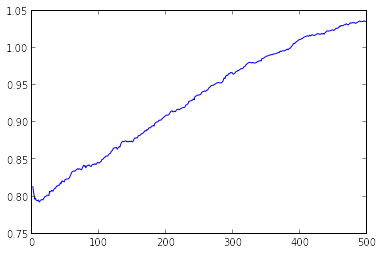

In [69]:
x = np.arange(params['n_estimators'])+1
plt.plot(x, cv_score)

Let's now do a grid search to tune the hyper parameteres

In [70]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}

gbc = GradientBoostingClassifier(n_estimators=100)
gs_cv = GridSearchCV(gbc, param_grid, n_jobs=4,
                     cv=KFold(n=analysis_df.shape[0], n_folds=3, shuffle=True, random_state=3),
                     refit=True).fit(analysis_df.values, Y.values)

These were the best settings

In [71]:
gs_cv.best_params_

{'learning_rate': 0.02, 'max_depth': 4, 'subsample': 0.9}

In [72]:
gs_cv.best_score_

0.85906735751295338

Let's take a look at which features were most informative

In [73]:
importances = gs_cv.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(analysis_df.shape[1]):
    print("%d. %s (%f)" % (f + 1, analysis_df.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Charlson (0.075651)
2. RDW (0.041747)
3. Hgb (0.038435)
4. gfr_max (0.034066)
5. RBC (0.029425)
6. NTAuto (0.028922)
7. CPT_80184 (0.023710)
8. Creat (0.022917)
9. SGOT (0.020404)
10. Monocy (0.017158)
11. GAS (0.015824)
12. MCHC (0.015239)
13. ICD_322 (0.014173)
14. gfr_discharge (0.014062)
15. CPT_J9181 (0.013665)
16. TProt (0.013340)
17. CPT_J2248 (0.012954)
18. MCH (0.012238)
19. ICD_536 (0.012018)
20. gfr_admit (0.011874)
21. CPT_76828 (0.011358)
22. LOS (0.011112)
23. CPT_80178 (0.010878)
24. WBC (0.010752)
25. CPT_78451 (0.010611)
26. PCV (0.010373)
27. Ca (0.010229)
28. PT-inr (0.010196)
29. BMI (0.009868)
30. CPT_76826 (0.009831)
31. ICD_337 (0.009729)
32. BUN (0.009250)
33. CPT_J3260 (0.009094)
34. Na (0.008936)
35. MCV (0.008812)
36. CPT_99356 (0.008250)
37. Alb (0.007824)
38. CPT_43264 (0.007682)
39. gfr_min (0.007585)
40. Plt-Ct (0.006610)
41. ICD_640 (0.006520)
42. CPT_93880 (0.006464)
43. SGPT (0.006275)
44. ICD_999 (0.005903)
45. ICD_526 (0.005899)
4

### Let's run down the top twenty features

Feature ranking:
1. Charlson (0.075651)
2. RDW (0.041747)
3. Hgb (0.038435)
4. gfr_max (0.034066)
5. RBC (0.029425)
6. NTAuto (0.028922)
7. CPT_80184 (0.023710)
8. Creat (0.022917)
9. SGOT (0.020404)
10. Monocy (0.017158)
11. GAS (0.015824)
12. MCHC (0.015239)
13. ICD_322 (0.014173)
14. gfr_discharge (0.014062)
15. CPT_J9181 (0.013665)
16. TProt (0.013340)
17. CPT_J2248 (0.012954)
18. MCH (0.012238)
19. ICD_536 (0.012018)
20. gfr_admit (0.011874)

The Charlson comorbidity score is the most important feature, which makes sense since patients with more medical problems are well known to be higher utilizers of healthcare and be at higher risk of readmission. The second feature, the RDW, is an indirect measure of red blood cell production--it has been shown to be predictive in other health outcome models. The third feature, the patient's hemoglobin would be a general indicator of a patient's health and also an independent predictor of readmission. Patients who are anemic tend to have more comorbidities and their anemia may directly contribute to readmission. The maximum gfr makes sense as a feature as a patient's kidney function has a large role to play in maintaining homeostasis and affects multiple other organ systems. The fifth feature, RBC, is another monitor of hemoglobin. The seventh feature CPT_80184 is a cpt code for a drug screen and may be an indicator of substance abuse for the patient, which would be a well known predictor for readmission.  The eight feature, creatinine, is another measure of kidney function. The ninth feature is a measure of liver function and makes sense as patients with liver disease are high utilizers of healthcare. It's not surprising to see the Gastroenterology service, the 11th feature, as many of these patients have chronic diseases (cirrhosis, inflammatory bowel disease, etc.) that predispose to readmission. The thirteenth feature, ICD code 322 for meningitis, makes sense as patients with serious infections would be at risk for readmission. The fourteenth feature looks at kidney function just at time of discharge.  The fifteenth feature is a HCPCS code for etoposide injection which is a chemotherapeutic agent--makes sense as oncologic patients have frequent admissions and complications. The 16th feature, the patients total protein can be a surrogate for overall health--as patients who are chronically ill tend to have lower protein levels. The 17th feature, the HCPCS code J2248, is the code for the injection of micafungin--an anti fungal medication used in severe infections. Patients with severe fungal infections are frequently immunocompromised, which in addition to the infection, would increase their likelihood of readmission. The 19th feature, ICD code 536, has to do with disorders of the stomach including gastroparesis--patients with gastroparesis are frequently admitted and readmitted for flares. The 20th feature looks at a patient's renal function at time of admission. Interestingly the model picked 4 different summary measures of renal function.